# Supervised Machine Learning: feature selection
Feature selection is aimed at identifying and selecting the most relevant and informative features from a given dataset. With the abundance of available features, selecting the right subset of variables can significantly impact the model's performance. By pruning irrelevant or redundant features, feature selection not only enhances the accuracy and generalisation capabilities of models but also reduces computational complexity, ensuring faster and more efficient predictions.

---
## 1.&nbsp;Import libraries 💾

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, RFECV, SelectFromModel

---
## 2.&nbsp;Creating the Dataset for Feature Selection 📂

In this step, we'll construct a diverse dataset. It includes both informative columns (strongly related to the label) and irrelevant ones (without any meaningful association with the label). You don't need to understand the intricacies of the dataset generation code; our focus lies in the feature selection we will perform on this dataset, rather than on the dataset generation itself.

In [ ]:
np.random.seed(123)
scale_values = np.logspace(1, 10, num=25)

X, y = make_regression(n_samples=1000,
                       n_features=25,
                       n_informative=6,
                       effective_rank=4,
                       noise=0.2,
                       random_state=42)

X = pd.DataFrame(X)
y = pd.DataFrame(y)

new_columns = {
    "25": np.random.normal(scale=1.1, loc=0.01, size=len(X)),
    "26": np.random.normal(scale=4, loc=1, size=len(X)),
    "27": np.full(len(X), 1.),
    "28": np.full(len(X), 0.),
    "29": np.concatenate([np.zeros(len(X)-1), [0.1]]),
    "30": X.iloc[:,3] * 0.823,
    "31": X.iloc[:,8] * np.random.normal(scale=0.3, loc=1, size=len(X))
}

X = X.assign(**new_columns)
X = X.add_prefix("feature_")
y = y.rename(columns={0:"label"})

original_df = pd.concat([X, y], axis=1)
original_df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,label
0,-0.018296,-0.001839,0.016016,-0.019307,0.001856,0.027113,0.013745,0.000633,0.017954,-0.009104,...,0.017348,-0.011803,-1.184194,-1.995310,1.0,0.0,0.0,-0.015890,0.008398,-0.076775
1,0.001363,-0.034291,-0.001782,-0.001157,-0.000928,0.021803,-0.017609,0.001054,0.000947,-0.016167,...,-0.023567,0.020733,1.107080,3.270379,1.0,0.0,0.0,-0.000952,0.000606,1.945816
2,-0.007991,0.013612,0.008775,-0.004530,0.002792,0.009852,0.004221,0.002174,-0.007749,0.016543,...,-0.005296,-0.006772,0.321276,3.872602,1.0,0.0,0.0,-0.003728,-0.010298,1.261298
3,-0.012161,0.021575,-0.008932,-0.007190,-0.010184,-0.016184,0.001812,-0.008250,-0.008352,-0.009462,...,-0.001067,0.006821,-1.646924,-2.997523,1.0,0.0,0.0,-0.005918,-0.010509,-4.510620
4,-0.029442,-0.005390,0.011258,0.024444,0.013054,-0.012449,-0.026195,0.025240,0.007042,-0.005765,...,-0.022302,0.011463,-0.626460,2.899593,1.0,0.0,0.0,0.020117,0.003830,3.017716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.004784,-0.005852,0.003786,-0.018332,0.017759,-0.011987,-0.019495,0.006243,0.014125,-0.007231,...,-0.017950,0.018817,0.708239,4.382805,1.0,0.0,0.0,-0.015087,0.013806,2.110393
996,0.029737,0.009150,0.011322,0.026551,0.007310,0.003309,-0.007107,0.021561,0.021082,0.020325,...,0.005461,-0.018409,1.186910,-3.479690,1.0,0.0,0.0,0.021852,0.015098,0.666808
997,0.009199,0.012291,0.021928,0.021705,-0.006578,-0.036746,-0.037261,-0.009584,0.019986,0.008848,...,-0.027405,0.007829,-0.990260,-0.437187,1.0,0.0,0.0,0.017864,0.032221,-1.141679
998,-0.002704,-0.011813,-0.002855,0.019239,0.000741,0.017812,-0.010176,0.000241,-0.010978,-0.002322,...,0.022012,-0.015817,0.527290,-5.438780,1.0,0.0,0.0,0.015834,-0.014323,-2.718885


---
## 3.&nbsp;Train-test split 🔀

All data transformations and feature selection should rely solely on the information from the training set, with no consideration of the test set. In feature selection, this involves deciding the usefulness of columns based only on the training set. Once we identify which columns to drop, we apply the same removal to the test set as well. For custom feature selection without SKLearn, it is vital to adhere to this principle of excluding any information from the test set during the feature selection process.

In [ ]:
X = original_df.copy()
y = X.pop("label")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

---
## 4.&nbsp;Baseline Model 🧱

In this codealong, we will focus on comparing the performance of two baseline models: a Decision Tree with default parameters and a K-Nearest Neighbors model with K=1. For simplicity, we won't be tuning the model parameters here. However, you are encouraged to explore parameter tuning independently. After applying each new feature selection strategy, we will track and evaluate the models to understand their impact on the predictive performance.

In [ ]:
baseline_tree = DecisionTreeRegressor()
baseline_tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [ ]:
baseline_knn = KNeighborsRegressor(n_neighbors=1)
baseline_knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=1)

Making predictions

In [ ]:
baseline_tree_pred = baseline_tree.predict(X_test)
baseline_knn_pred = baseline_knn.predict(X_test)

In this evaluation, we will utilise R-squared to assess our models' performance and gauge the impact of our feature selection process. While having a primary metric is recommended, exploring multiple metrics can provide diverse insights into the model's behavior. Therefore, feel free to explore alternative evaluation metrics to gain a more comprehensive understanding of your model's strengths and weaknesses.

In [ ]:
baseline_tree_r2 = r2_score(y_test, baseline_tree_pred)
baseline_knn_r2 = r2_score(y_test, baseline_knn_pred)

performances = pd.DataFrame({'decision_tree': baseline_tree_r2,
                             'knn': baseline_knn_r2},
                            index=['baseline'])

performances

,decision_tree,knn
baseline,0.803226,-1.010195


You can already see how a Decision Tree handles a noisy dataset much better than K-Nearest Neighbors. Decision Trees selectively consider only the "best" features in the algorithm, while K-Nearest Neighbors treats all features equally. However, it's essential to remember that the Decision Tree might not always be the better choice; after preprocessing, K-Nearest Neighbors could potentially perform better.

> **Note:** A negative R-squared score suggests that the KNN model performs worse than a horizontal line, indicating that it fails to capture any meaningful relationships between the input features and the target variable.

---
## 5.&nbsp;Feature selection based only on features 🔨

### 5.1.&nbsp;Variance Threshold

Features with low variance carry limited information, and with this transformer, we can eliminate those features by setting a threshold. Any feature with a variance below this threshold will be dropped from the dataset. It's essential to consider that column variance is influenced by its scale; while most columns in our dataset have a small range, features 25 and 26 stand out with more significant variability.

Let's first look at the range and variance of the columns.

In [ ]:
range_var_df = (pd.DataFrame({
                'Range': X_train.max() - X_train.min(),
                'Variance': X_train.var()})
                .sort_values(by='Variance'))

In [ ]:
range_var_df.head()

,Range,Variance
feature_28,0.000000,0.000000
feature_27,0.000000,0.000000
feature_29,0.100000,0.000013
feature_4,0.084589,0.000134
feature_2,0.080179,0.000136


In [ ]:
range_var_df.tail()

,Range,Variance
feature_5,0.112041,0.000342
feature_14,0.125454,0.000366
feature_13,0.146743,0.000426
feature_25,7.412498,1.206981
feature_26,25.429091,14.743576


The large variance observed in columns 25 and 26 could be attributed to their wider value range. It's important to note that this makes a direct comparison of their variances with other columns less meaningful due to the scale differences. Therefore, **it's a good idea to scale the features before removing those with the smallest variance**.

#### 5.1.1.&nbsp;Scaling the data

Certain scaling processes can result in transforming features to have the same variance, like the standard scaler, which changes the standard deviation to 1. However, this is **not** our desired outcome. We need to choose a scaler that preserves variance, and for this purpose, we will use min-max scaling.

In [ ]:
# Initialize the scaler.
my_scaler = MinMaxScaler().set_output(transform="pandas")

# Fit the scaler to X_train and transform the values.
X_train_scaled = my_scaler.fit_transform(X_train)

Let's examine how the scaling impacted the range and variance of our columns, with a specific focus on columns 25 and 26.

In [ ]:
(
  pd.DataFrame({
  'Range': X_train_scaled.max() - X_train_scaled.min(),
  'Variance': X_train_scaled.var()})
  .sort_values(by='Variance')
)

,Range,Variance
feature_28,0.0,0.000000
feature_27,0.0,0.000000
feature_29,1.0,0.001250
feature_9,1.0,0.015667
feature_22,1.0,0.016657
feature_4,1.0,0.018682
feature_13,1.0,0.019783
feature_2,1.0,0.021117
feature_0,1.0,0.021403
feature_12,1.0,0.021515


After scaling features 25 and 26 no longer have the largest variances. Now, we can proceed with applying the `VarianceThreshold` transformation.

All features with a smaller variance than the `threshold` will be deleted from the dataset.

In [ ]:
selector = VarianceThreshold(threshold=0.02)

X_train_var = selector.fit_transform(X_train_scaled)

Let's check how many features were dropped:

In [ ]:
print("shape before:", X_train_scaled.shape)
print("shape after:", X_train_var.shape)

shape before: (800, 32)
shape after: (800, 25)


We have dropped `7` features using a threshold of `0.02`. Feel free to adjust the threshold if you wish to drop more or fewer features.

> **Note:** It's generally not advisable to drop many features with this transformer, as some features might contain crucial information, even if they have low variance. For instance, consider a feature in the Housing dataset representing the number of "Private Helicopters." Though it may have a small variance due to most houses having `0` helicopters, the presence of one helicopter can significantly impact the house price. Hence, it's essential to be cautious when dropping features, and it is usually safe to remove only features with zero variance as they offer no valuable information.

The next step: make sure to transform the test set using the `transform` method. Remember to avoid using the `fit_transform` method, as it is reserved exclusively for the train set. This way, you ensure proper feature scaling without introducing data leakage from the test set into the model.

In [ ]:
# Scale the test set
X_test_scaled = my_scaler.transform(X_test)

# Apply the variance threshold to the scaled test set
X_test_var = selector.transform(X_test_scaled)

Let's check how well our model performs with the new dataset.

In [ ]:
# Decision tree.
var_tree = DecisionTreeRegressor()
var_tree.fit(X_train_var, y_train)
var_tree_pred = var_tree.predict(X_test_var)

# K-Nearest Neighbors.
var_knn = KNeighborsRegressor(n_neighbors=1)
var_knn.fit(X_train_var, y_train)
var_knn_pred = var_knn.predict(X_test_var)

performances.loc["varThreshold_0_02", "decision_tree"] = r2_score(y_test, var_tree_pred)
performances.loc["varThreshold_0_02", "knn"] = r2_score(y_test, var_knn_pred)

performances

,decision_tree,knn
baseline,0.803226,-1.010195
varThreshold_0_02,0.578182,0.180197


Although the performance of our K-Nearest Neighbors model improved, the Decision Tree model's performance degraded significantly, implying that the dropped columns contained valuable information. Such outcomes are not uncommon when using the variance threshold.

Let's repeat the process with a more conservative threshold to explore if it makes a difference in preserving important features.

#### 5.1.2.&nbsp;Scaling the data: 2nd iteration
Set the threshold to 0, meaning we will remove only those columns with zero variance. This will help us eliminate features that carry no valuable information.

In [ ]:
selector2 = VarianceThreshold(threshold=0).set_output(transform="pandas")
X_train_var2 = selector2.fit_transform(X_train_scaled)

print("shape before:", X_train_scaled.shape)
print("shape after:", X_train_var2.shape)

shape before: (800, 32)
shape after: (800, 30)


We have only dropped 2 features that had zero variance. Let's see how this impacts performance.

In [ ]:
X_test_var2 = selector2.transform(X_test_scaled)

In [ ]:
# Decision tree.
var2_tree = DecisionTreeRegressor()
var2_tree.fit(X_train_var2, y_train)
var2_tree_pred = var2_tree.predict(X_test_var2)

# K-Nearest Neighbors.
var2_knn = KNeighborsRegressor(n_neighbors=1)
var2_knn.fit(X_train_var2, y_train)
var2_knn_pred = var2_knn.predict(X = X_test_var2)

performances.loc["varThreshold_0_00", "decision_tree"] = r2_score(y_test, var2_tree_pred)
performances.loc["varThreshold_0_00", "knn"] = r2_score(y_test, var2_knn_pred)

performances

,decision_tree,knn
baseline,0.803226,-1.010195
varThreshold_0_02,0.578182,0.180197
varThreshold_0_00,0.814704,0.338966


That's made an improvement in both models!

### 5.2.&nbsp; Collinearity

Features that have a perfect (or extremely high) correlation with each other can be considered to be the same feature. We want to drop one of them. Let's first explore the pairwise correlations between all features.

To quickly identify highly correlated columns, we can create a heatmap displaying their correlations, allowing us to easily spot extreme values.

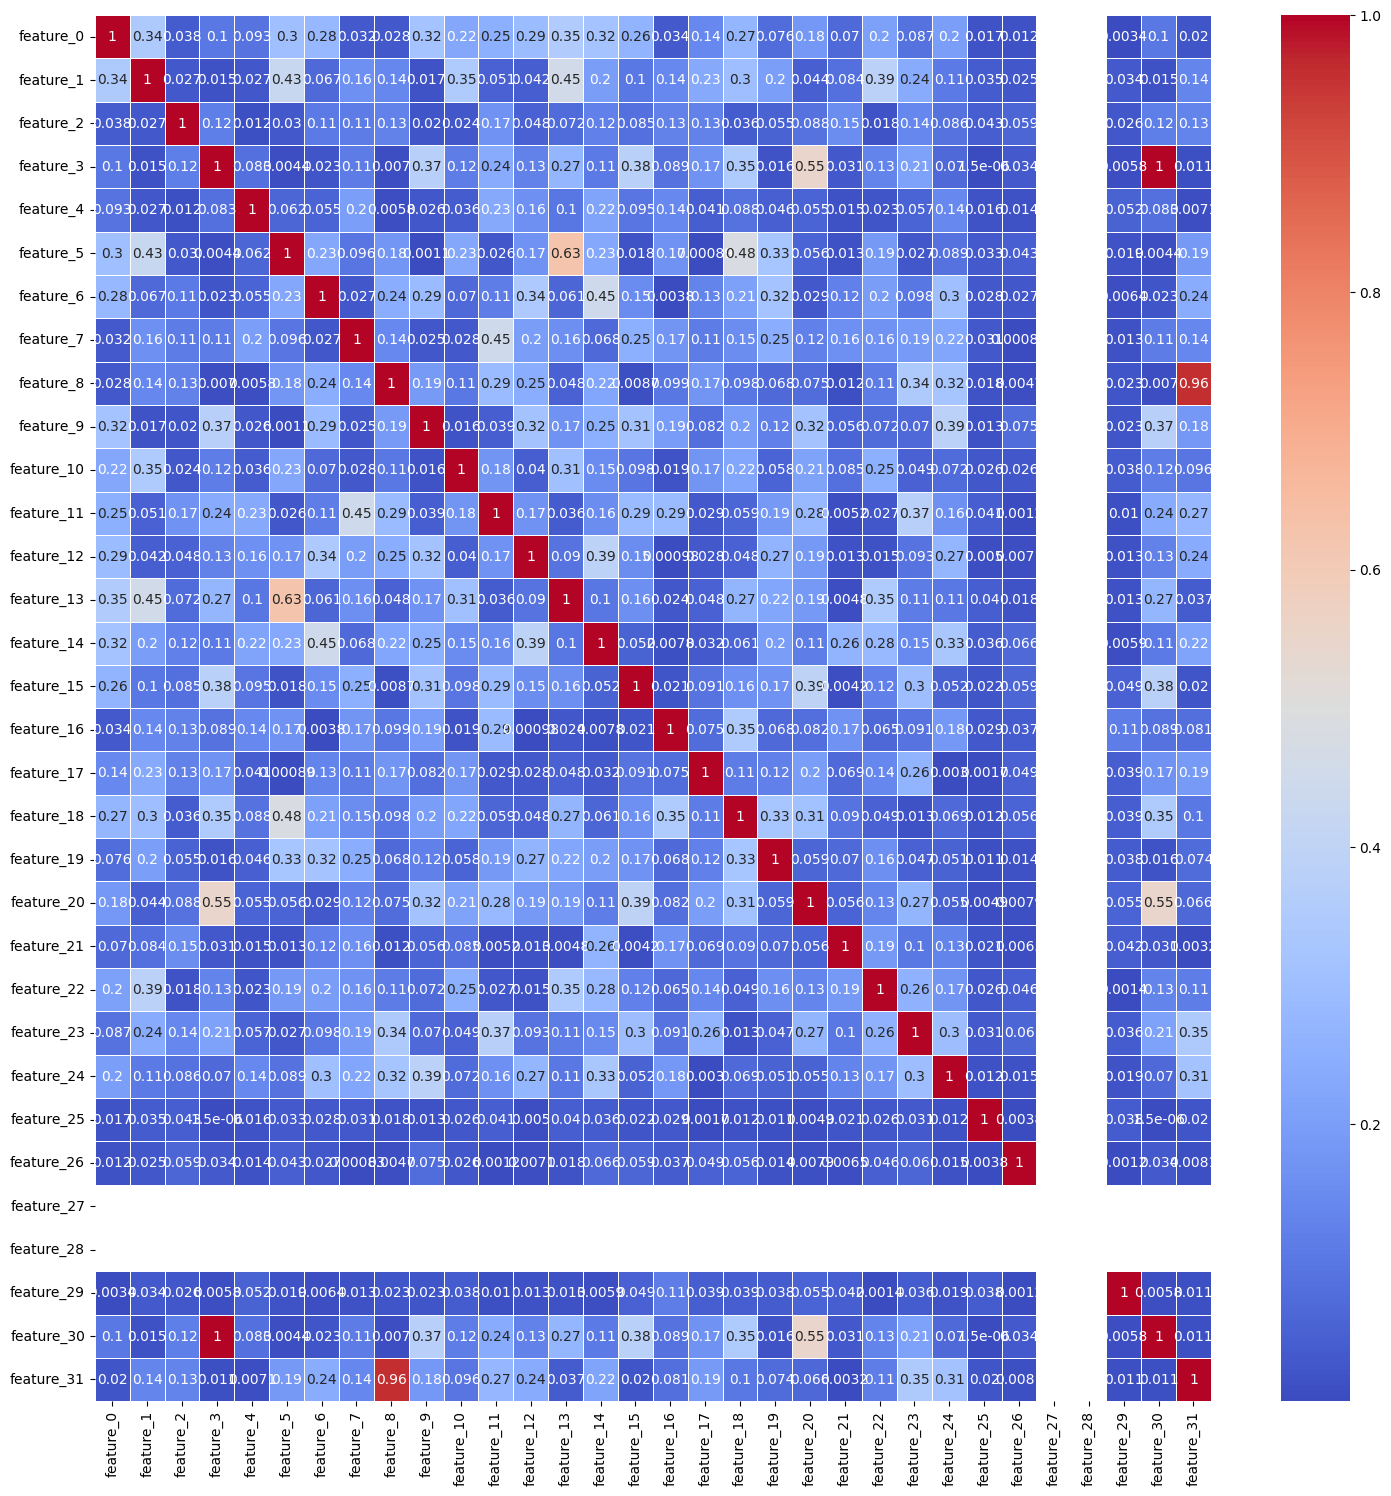

In [ ]:
# Calculate the absolute correlation matrix for the feature matrix X_train_var2
corrMatrix = X_train.corr().abs()

# Set the size of the heatmap to be 18x18 inches
plt.figure(figsize=(18, 18))

# Create a heatmap using Seaborn (sns) to visualize the correlation matrix
# 'annot=True' adds the correlation values to the cells for better readability
# 'cmap='coolwarm'' specifies the color map to be used, with warm colors (red) for positive correlations
# and cool colors (blue) for negative correlations
# 'linewidths' sets the width of the white lines around the squares
sns.heatmap(corrMatrix,
            annot=True,
            cmap='coolwarm',
            linewidths=0.5);

>**Note:** Columns 27 and 28 do not appear in the heatmap because they have 0 variance, meaning all their values are the same. When calculating the correlation coefficient, the denominator is the standard deviation of the column. As the standard deviation of these columns is 0, division by 0 occurs, resulting in NaN values.

From the heatmap we can see how there is a pair of columns with a _perfect_  correlation (`1`) and another pair of columns with a very high correlation (`0.96`). The rest of the correlation coefficients are much smaller and can be neglected at this stage.

If you have too many column to view on a heatmap, we can loop through the columns to identify the correlated columns.

In [ ]:
# Set the correlation threshold to consider columns as highly correlated
correlation_threshold = 0.95

# Initialise an empty list to store the pairs of highly correlated columns
highly_correlated_columns = []

# Get the number of features (columns) in the correlation matrix
num_features = len(corrMatrix.columns)

# Loop through the upper triangle of the correlation matrix to find highly correlated columns
# Note: We start from i+1 to avoid redundancy as correlation_matrix is symmetric
for i in range(num_features):
    for j in range(i + 1, num_features):
        # Check if the correlation value between columns i and j is greater than or equal to the threshold
        if corrMatrix.iloc[i, j] >= correlation_threshold:
            # Append the tuple (column_i, column_j) to the list of highly correlated columns
            highly_correlated_columns.append((corrMatrix.columns[i], corrMatrix.columns[j], f"correlation = {round(corrMatrix.iloc[i, j], 2)}"))

# Print the pairs of highly correlated columns
print("Highly correlated columns:", highly_correlated_columns)

Highly correlated columns: [('feature_3', 'feature_30', 'correlation = 1.0'), ('feature_8', 'feature_31', 'correlation = 0.96')]


Since each tuple in our list contains 2 columns, we need to ensure we drop only one of them.

In [ ]:
fruits = ['apple','pear','grapes','banana','ananas']

In [ ]:
[fruit.startswith('a') for fruit in fruits]

[True, False, False, False, True]

In [ ]:
to_drop = [element_a for element_a, element_b, element_c in highly_correlated_columns]
to_drop

['feature_3', 'feature_8']

After identifying the columns to drop, we proceed to remove them from both the train and the test sets.
> **Note:** Normally students do this outside of the pipeline; with correlation it's hard to include a custom function in the pipeline using [Function Transformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html). This is hard to do as it normally removes different columns from the train and test set. The best solution to this is to create a class and include fit and tranform methods in the class. As this is more advanced than our course, please ask you instructor for an example if you're feeling inquisitive.

In [ ]:
# Drop the columns from the train set.
X_train_corr = X_train.drop(columns=to_drop).copy()

# Drop the columns from the test set.
X_test_corr = X_test.drop(columns=to_drop).copy()

Let's check the performance again:

In [ ]:
# Decision tree.
corr_tree = DecisionTreeRegressor()
corr_tree.fit(X_train_corr, y_train)
corr_tree_pred = corr_tree.predict(X_test_corr)

# K-Nearest Neighbors.
corr_knn = KNeighborsRegressor(n_neighbors=1)
corr_knn.fit(X_train_corr, y_train)
corr_knn_pred = corr_knn.predict(X_test_corr)

performances.loc["collinearity", "decision_tree"] = r2_score(y_test, corr_tree_pred)
performances.loc["collinearity", "knn"] = r2_score(y_test, corr_knn_pred)

performances

,decision_tree,knn
baseline,0.803226,-1.010195
varThreshold_0_02,0.578182,0.180197
varThreshold_0_00,0.814704,0.338966
collinearity,0.816740,-0.980851


We observe that collinearity had a minor impact compared to our baseline model. However, it did not contribute as significantly to improving the KNN model compared to setting the variance threshold to 0.

---
## 6.&nbsp;Feature selection based on features and labels 🔧

### 6.1.&nbsp;K Best

Select K Best allows us to use statistical tests like ANOVA or chi2 to rank and select the best features. Refer to the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) and [user guide](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) to see the model's methods, understand its parameters, and explore examples. If the documentation seems challenging, search for tutorials online.

We will have to choose an appropriate statistical test based on the data type: for our regression problem, an f-test will be used. Visit [Ben Lambert's Youtube channel](https://www.youtube.com/watch?v=ie-MYQp1Nic&ab_channel=BenLambert) for detailed explanations and examples on the f-test.

In short, Scikit-Learn computes the f-statistic for each univariate linear model (one for each feature). The f-statistic measures how much better the linear model with a single feature predicts compared to using only a constant value. This "score" allows us to rank the features.

For better understanding, let's run the statistical test and examine the f-statistics of each feature.

In [ ]:
# Run the univariate (= one feature at a time) linear regression tests.
f_stat, _ = f_regression(X_train, y_train)

# Create a DataFrame with the f-statistics and p-values.
f_test = pd.DataFrame({"f_stat":f_stat},
                      index=X_train.columns)

# Sort the values in the f-statistic column.
f_test.sort_values("f_stat", ascending=False)

,f_stat
feature_16,613.642293
feature_17,574.378182
feature_4,317.693750
feature_18,77.020510
feature_11,60.709343
feature_7,53.810295
feature_1,42.225456
feature_23,29.215578
feature_31,19.905804
feature_20,18.498722


Above, we have a ranking of the "best" features based on their individual predictive ability in a linear model. The SelectKBest transformer performs this test and allows you to control the number of "top" features to retain using the K parameter. For our initial selection, we will set K=10, but feel free to adjust this value as needed.

> **Note:** In a pipeline with `GridSearchCV`, you can fine-tune the `K` parameter by trying out various possible values, along with other preprocessing and modeling parameters. Machine Learning often involves automated search or optimisation techniques to find the best parameter values, and it is normal not to have to intuitively know the ideal parameter values from the outset.

In [ ]:
# Initialise KBest, using the f-regression and setting k=10.
KBest = SelectKBest(score_func=f_regression, k=10)

As always, after initialising the transformer we fit it to the train set and transform both the train and the test set:

In [ ]:
# Transform the train set.
X_train_KBest = KBest.fit_transform(X_train, y_train).copy()

# Transform the test set.
X_test_KBest = KBest.transform(X_test).copy()

Now, you can see how both the train and the test set have only 10 features.

In [ ]:
X_train_KBest.shape, X_test_KBest.shape

((800, 10), (200, 10))

Let's see how our models perform with these 10 "best" features:

In [ ]:
# Decision tree.
k10_tree = DecisionTreeRegressor()
k10_tree.fit(X_train_KBest, y_train)
k10_tree_pred = k10_tree.predict(X_test_KBest)

# K-Nearest Neighbors.
k10_knn = KNeighborsRegressor(n_neighbors=1)
k10_knn.fit(X_train_KBest, y_train)
k10_knn_pred = k10_knn.predict(X_test_KBest)

performances.loc["KBest_10", "decision_tree"]= r2_score(y_test, k10_tree_pred)
performances.loc["KBest_10", "knn"] = r2_score(y_test, k10_knn_pred)

performances

,decision_tree,knn
baseline,0.803226,-1.010195
varThreshold_0_02,0.578182,0.180197
varThreshold_0_00,0.814704,0.338966
collinearity,0.816740,-0.980851
KBest_10,0.832593,0.606619


The performance of both models has increased significantly! It's possible it would increase even more by tuning the value of `K`.

### 6.2.&nbsp;Recursive Feature Elimination

Recursive Feature Elimination (RFE) is an automatic feature selection technique that efficiently identifies the most relevant features from a dataset. It begins by training a chosen model on all features and recording its performance. Then, it iteratively removes the least important features based on their importance rankings, continuously evaluating model performance. As long as the performance remains steady or improves, RFE keeps dropping features one by one. Once the performance starts to decline, it stops and saves the model, eliminating the need for manual or fine-tuning decisions on the number of features to keep.

However, it's essential to use a model capable of computing "feature importances" for RFE to be effective, and tree-based models are generally suitable for this purpose, unlike models like KNN. In scikit-learn, you can check if the model has an attribute called `feature_importances_`.

For more details, refer to the documentation and user guide here: [scikit-learn RFE documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html). Before proceeding, let's explore the ranked list of features returned by RFE to gain a better understanding of their importance.

In [ ]:
rfe_tree = RFECV(DecisionTreeRegressor(random_state=123))
rfe_tree.fit(X_train, y_train)
rfe_tree_pred = rfe_tree.predict(X_test)

performances.loc["RFE", "decision_tree"] = r2_score(y_test, rfe_tree_pred)

performances

,decision_tree,knn
baseline,0.803226,-1.010195
varThreshold_0_02,0.578182,0.180197
varThreshold_0_00,0.814704,0.338966
collinearity,0.816740,-0.980851
KBest_10,0.832593,0.606619
RFE,0.860387,NaN


Great news! The model's performance has increased once more!

To extract the names of the features selected by RFE, you can refer to the `rfe_tree` object.

In [ ]:
rfe_tree.get_feature_names_out()

array(['feature_4', 'feature_16', 'feature_17'], dtype=object)

It appears that only three features were retained! Interestingly, these three features align with the top-ranking features from `SelectKBest`, which is reasonable since proper tuning of the `K` parameter could lead both methods to converge eventually. Nevertheless, this may not always be the case: RFE can detect valuable non-linear interactions between multiple features, as it checks how features work in combination with each other, while SelectKBest relies on univariate selection (checking features individually with the target).

> **Note:** When you encounter methods like `get_feature_names_out()` in pre-made notebooks, it might seem as if you needed to know them in advance. However, what's important is to be aware that Scikit-Learn transformer objects often store valuable information after being fitted. To access such information, always refer to the documentation for available attributes and methods, and search for what you need. In such a case, a simple search like "which features are selected in SelectKBest" would also yield helpful results.

### 6.3.&nbsp;Select from model

[SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html?highlight=selectfrommodel#sklearn.feature_selection.SelectFromModel) leverages the importance scores provided by a model to select the most relevant features from a given dataset. The process involves training a model on the entire feature set, obtaining the feature importances or coefficients from the model, and then selecting the features based on a specified threshold. If you don't include a threshold, SelectFromModel will automatically select the best features for you, using the model's inherent feature importance ranking. This approach is particularly useful for models that inherently provide feature importances, such as tree-based models or linear models, allowing us to focus on the most influential features and improve model performance while reducing complexity.
> **Note:** SelectFromModel may seem similar to RFE since both methods use inherent feature importance scores, but they operate differently. Unlike RFE, SelectFromModel solely concentrates on the top features based on their individual predictive power, without considering interactions between features.

In [ ]:
select_model_tree = SelectFromModel(DecisionTreeRegressor(),
                                    threshold=None)

In [ ]:
# Transform the train set.
X_train_selected_model_tree = select_model_tree.fit_transform(X_train, y_train)

# Transform the test set.
X_test_selected_model_tree = select_model_tree.transform(X_test)

In [ ]:
# Show shape of the train and test dataset to check for the number of features kept.
print(X_train_selected_model_tree.shape, X_test_selected_model_tree.shape)

(800, 3) (200, 3)


Once again, only three features were retained. When different methods converge towards the same output, it instills confidence in the selection, indicating a robust choice.

In [ ]:
select_model_tree.get_feature_names_out()

array(['feature_4', 'feature_16', 'feature_17'], dtype=object)

We can now try how both the Decision Tree and the KNN perform with these three features:

In [ ]:
# Decision tree.
select_model_tree = DecisionTreeRegressor()
select_model_tree.fit(X_train_selected_model_tree, y_train)
select_model_tree_pred = select_model_tree.predict(X_test_selected_model_tree)

# K-Nearest Neighbors.
select_model_knn = KNeighborsRegressor(n_neighbors=1)
select_model_knn.fit(X_train_selected_model_tree, y_train)
select_model_knn_pred = select_model_knn.predict(X_test_selected_model_tree)

performances.loc["model_selected", "decision_tree"] = r2_score(y_test, select_model_tree_pred)
performances.loc["model_selected", "knn"] = r2_score(y_test, select_model_knn_pred)

performances

,decision_tree,knn
baseline,0.803226,-1.010195
varThreshold_0_02,0.578182,0.180197
varThreshold_0_00,0.814704,0.338966
collinearity,0.816740,-0.980851
KBest_10,0.832593,0.606619
RFE,0.860387,NaN
model_selected,0.856518,0.922235


Surprisingly, the KNN model has suddenly shown significant improvement with this combination of features! This serves as a valuable lesson on how algorithms can react differently to the same preprocessing and feature selection strategy. It highlights the importance of exploring various approaches to find the most suitable one for specific datasets and models.

---
## 7.&nbsp;Challenge 😃

Incorporate feature selection into your Housing Regression Pipeline. While you don't have to apply all the methods shown here, we suggest experimenting with 2-3 methods and ultimately choosing one. Research how to **integrate feature selection into your Scikit-Learn pipeline** and consider tuning it with GridSearchCV, which will enhance the cohesiveness of your ML workflow, though it's not mandatory. Happy experimenting!

In [ ]:
# good luck!